In [39]:
import cv2
import numpy as np
import os
from PIL import Image
from skimage.morphology import medial_axis, skeletonize
import matplotlib.pyplot as plt
%matplotlib inline
import imutils

In [60]:
def show_image(*image):
    plt.figure(figsize=(16,15))
    plt.imshow(image[0],cmap="gray")
    if len(image)>1 : plt.title(image[1])
    plt.show()
#########################################################
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
#########################################################
def select_largest_obj(img_bin, lab_val=255, fill_holes=False, 
                           smooth_boundary=False, kernel_size=15):
    #show_image(img_bin,"Original")
    n_labels, img_labeled, lab_stats, _ = \
            cv2.connectedComponentsWithStats(img_bin, connectivity=8, 
                                             ltype=cv2.CV_32S)
    largest_obj_lab = np.argmax(lab_stats[1:, 4]) + 1
    largest_mask = np.zeros(img_bin.shape, dtype=np.uint8)
    largest_mask[img_labeled == largest_obj_lab] = lab_val
    # import pdb; pdb.set_trace()
    if fill_holes:
        bkg_locs = np.where(img_labeled == 0)
        bkg_seed = (bkg_locs[0][0], bkg_locs[1][0])
        img_floodfill = largest_mask.copy()
        h_, w_ = largest_mask.shape
        mask_ = np.zeros((h_ + 2, w_ + 2), dtype=np.uint8)
        cv2.floodFill(img_floodfill, mask_, seedPoint=bkg_seed, 
                      newVal=lab_val)
        holes_mask = cv2.bitwise_not(img_floodfill)  # mask of the holes.
        largest_mask = largest_mask + holes_mask
    if smooth_boundary:
        kernel_ = np.ones((kernel_size, kernel_size), dtype=np.uint8)
        largest_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_OPEN, 
                                        kernel_)
    return largest_mask 
####################################################
def single_pixel(image):
    skel, distance = medial_axis(image, return_distance=True)
    dist_on_skel = distance * skel
    dist_on_skel = dist_on_skel.astype('uint8')
    for i in range (0,dist_on_skel.shape[0]):
        for j in range(0,dist_on_skel.shape[1]):
            if dist_on_skel[i][j]>0:
                dist_on_skel[i][j] = 1
    return dist_on_skel
####################################################
def find_end_points(masked_image):
    if masked_image.shape.index(np.array(masked_image.shape).max())==1:
        for each in range(masked_image.shape[1]):
            if sum(masked_image[:,each])!=0:
                start_column = each
                for each_value in masked_image[:,each]:
                    if each_value>0:
                        start_row = list(masked_image[:,each]).index(each_value)
                        break
                break
        for each in range(masked_image.shape[1]-1,1,-1):
            if sum(masked_image[:,each])!=0:
                end_column = each
                for each_value in masked_image[:,each]:
                    if each_value>0:
                        end_row = list(masked_image[:,each]).index(each_value)
                        break
                break
    else:
        for each in range(masked_image.shape[0]):
            if sum(masked_image[each,:])!=0:
                start_row = each
                for each_value in masked_image[each,:]:
                    if each_value>0:
                        start_column = list(masked_image[each,:]).index(each_value)
                        break
                break
        for each in range(masked_image.shape[0]-1,1,-1):
            if sum(masked_image[each,:])!=0:
                end_row = each
                for each_value in masked_image[each,:]:
                    if each_value>0:
                        end_column = list(masked_image[each,:]).index(each_value)
                        break
                break
    return [start_column,start_row,end_column,end_row]



In [45]:
'''dist_on_skel = dist_on_skel.astype('uint8')
for i in range (0,dist_on_skel.shape[0]):
    for j in range(0,dist_on_skel.shape[1]):
        if dist_on_skel[i][j]>0:
            dist_on_skel[i][j] = 1
print(dist_on_skel.max())
plt.figure(figsize=(16,15))
plt.imshow(dist_on_skel, cmap='gray')'''

"dist_on_skel = dist_on_skel.astype('uint8')\nfor i in range (0,dist_on_skel.shape[0]):\n    for j in range(0,dist_on_skel.shape[1]):\n        if dist_on_skel[i][j]>0:\n            dist_on_skel[i][j] = 1\nprint(dist_on_skel.max())\nplt.figure(figsize=(16,15))\nplt.imshow(dist_on_skel, cmap='gray')"

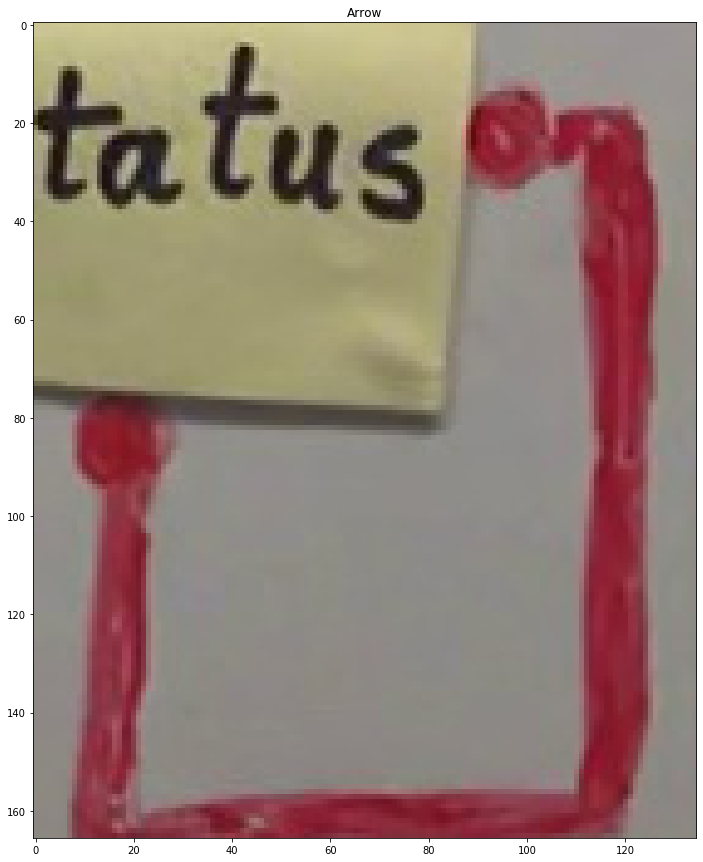

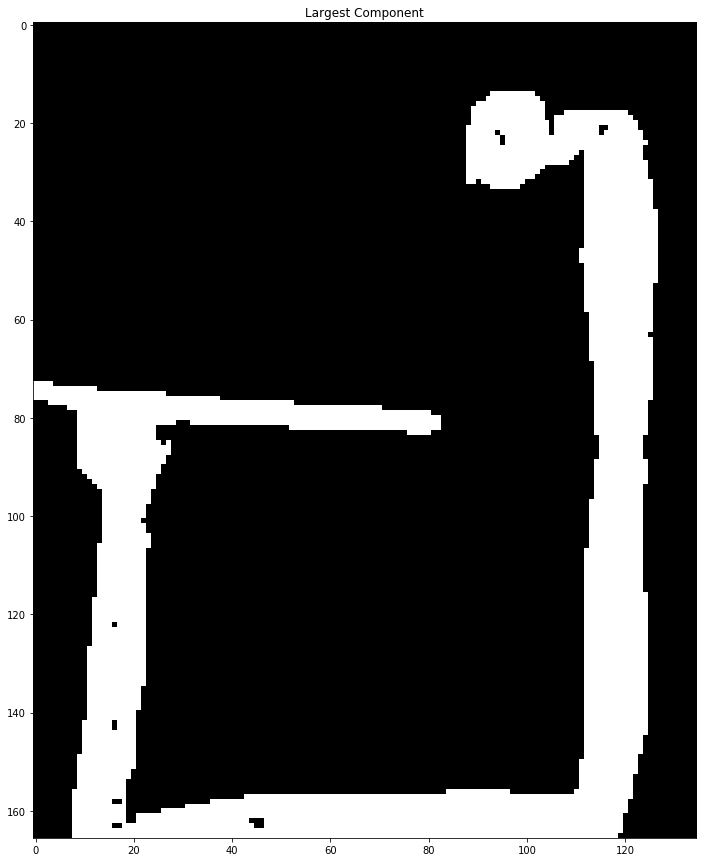

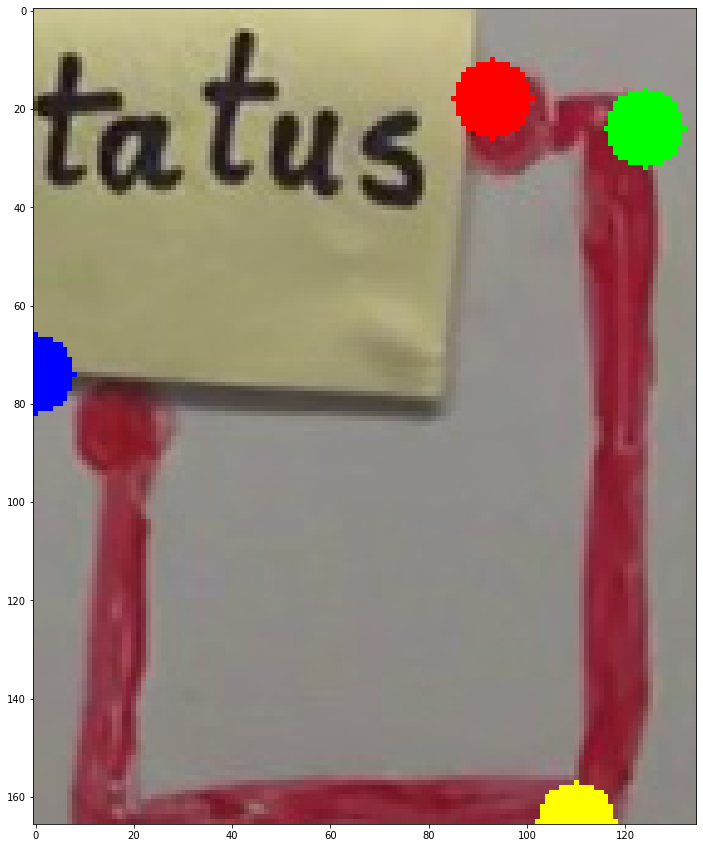

In [72]:
images = os.listdir("/Users/ankitkpr93/UTS projects/codebot/384/")
for each in images:
    image = Image.open("/Users/ankitkpr93/UTS projects/codebot/384/%s"%each)
    (H,W)=image.size[:2]
    image_np = load_image_into_numpy_array(image)
    subset=image_np
    #show_image(image_np,"Original Image")
    subset = image_np[888:1054,1417:1552]
    show_image(subset,"Arrow")
    gray_subset = cv2.cvtColor(subset,cv2.COLOR_RGB2GRAY)
    ret, binary_img = cv2.threshold(gray_subset, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    #cv2.rectangle(image_np, (499, 566), (1271, 987), (255, 0, 255), 3,5)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    #show_image(binary_img,"Binary Image")
    #cv2.imwrite("original_binary.jpg",binary_img)
    largest_component = select_largest_obj(binary_img)
    show_image(largest_component,"Largest Component")
    thinned_image = single_pixel(largest_component)
    #show_image(thinned_image,"Thinned Image")
    location = find_end_points(thinned_image)
    #print(location)
    #cv2.circle(image_np,(location[2],location[3]),4,(255,255,0),-1)
    #cv2.circle(image_np,(location[0],location[1]),4,(0,255,255),-1)
    #show_image(image_np)
    cnts = cv2.findContours(thinned_image, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    #cv2.drawContours(image_np, [c], -1, (0, 255, 255), 2)
    cv2.circle(subset, extLeft, 8, (0, 0, 255), -1)
    cv2.circle(subset, extRight, 8, (0, 255, 0), -1)
    cv2.circle(subset, extTop, 8, (255, 0, 0), -1)
    cv2.circle(subset, extBot, 8, (255, 255, 0), -1)
    cv2.imwrite("arrow4.png",subset)
    show_image(subset)
    break